In [ ]:
#Used to mount google drive to colab so that files can be accessed from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing necessary libraries for the project 
import tensorflow as tf
from keras.utils import image_dataset_from_directory
from keras.applications.vgg16 import VGG16
from tensorflow import keras
from keras import layers

In [ ]:
# Directories
#specifying the directories where the datasets of train, validation and test are stored
train_dirs = [
    '/content/drive/MyDrive/ProjetoIA/dataset/train1',
    '/content/drive/MyDrive/ProjetoIA/dataset/train2',
    '/content/drive/MyDrive/ProjetoIA/dataset/train4',
    '/content/drive/MyDrive/ProjetoIA/dataset/train5'
]
validation_dir = '/content/drive/MyDrive/ProjetoIA/dataset/train3'
test_dir = '/content/drive/MyDrive/ProjetoIA/dataset/test'

# Parameters
IMG_SIZE = 150
BATCH_SIZE = 32

# Function to load datasets from multiple directories and concatenate them
def load_and_concatenate_datasets(directories, img_size, batch_size):
    datasets = [] #list to store the datasets
    for directory in directories:
        # Load dataset from directory
        dataset = image_dataset_from_directory(
            directory,
            image_size=(img_size, img_size),
            batch_size=batch_size
        )
        datasets.append(dataset) #append the dataset to the list
    return datasets

# Load train datasets and concatenate
train_datasets = load_and_concatenate_datasets(train_dirs, IMG_SIZE, BATCH_SIZE)
#combine the train datasets in a unique dataset
train_dataset = tf.data.Dataset.sample_from_datasets(train_datasets)

# Load validation and test datasets
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Extract class names from one of the datasets
example_dataset = image_dataset_from_directory(
    train_dirs[0],
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
class_names = example_dataset.class_names
print(class_names) 

Found 10400 files belonging to 10 classes.
Found 9600 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 1 classes.
Found 10400 files belonging to 10 classes.
['000_airplane', '001_automobile', '002_bird', '003_cat', '004_deer', '005_dog', '006_frog', '007_horse', '008_ship', '009_truck']


In [ ]:
# Build the model
# Create the base model from the pre-trained model VGG16 with weights from ImageNet
# excluding the top layers

# Fine-tuning the model
conv_base = VGG16(weights="imagenet", include_top=False)
conv_base.trainable = True #defining that the convolutional base is trainable
for layer in conv_base.layers[:-2]: #excluding the last two layers
    layer.trainable = False #defining that the layers are not trainable

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Data augmentation
#Flip horizontal ramdomly, rotate randomly 10%, and zoom randomly 20%
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(150, 150, 3)) # defining the input shape, considering the image redimensioned to 150x150 with 3 channels(RGB)
x = data_augmentation(inputs) #applying the transformations of the data augmentation
x = keras.applications.vgg16.preprocess_input(x)  # Apply input value scaling
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Compile the model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

In [ ]:
# Adding ModelCheckpoint callback
# its for saving the best model based on the validation loss
# and has a patience of 5 epochs to avoid overfitting
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/ProjetoIA/models/CNN_modeloT_TL_FT_with_DA_best.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1)

In [ ]:
# Train the model with fine-tuning and checkpointing
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[checkpoint_cb, early_stop]
)

# Save the final model
model.save('/content/drive/MyDrive/ProjetoIA/models/CNN_modeloT_TL_FT_with_DA.h5')

Epoch 1/30
   1251/Unknown - 432s 343ms/step - loss: 4.7180 - accuracy: 0.3935
Epoch 1: val_loss improved from inf to 1.10213, saving model to /content/drive/MyDrive/ProjetoIA/models/CNN_modeloT_TL_FT_with_DA_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1251/1251 [==============================] - 525s 417ms/step - loss: 4.7180 - accuracy: 0.3935 - val_loss: 1.1021 - val_accuracy: 0.6955
Epoch 2/30
1251/1251 [==============================] - ETA: 0s - loss: 1.5968 - accuracy: 0.5622
Epoch 2: val_loss improved from 1.10213 to 0.78613, saving model to /content/drive/MyDrive/ProjetoIA/models/CNN_modeloT_TL_FT_with_DA_best.h5
1251/1251 [==============================] - 507s 405ms/step - loss: 1.5968 - accuracy: 0.5622 - val_loss: 0.7861 - val_accuracy: 0.7512
Epoch 3/30
1251/1251 [==============================] - ETA: 0s - loss: 1.2200 - accuracy: 0.6291
Epoch 3: val_loss improved from 0.78613 to 0.67552, saving model to /content/drive/MyDrive/ProjetoIA/models/CNN_modeloT_TL_FT_with_DA_best.h5
1251/1251 [==============================] - 503s 401ms/step - loss: 1.2200 - accuracy: 0.6291 - val_loss: 0.6755 - val_accuracy: 0.7887
Epoch 4/30
1251/1251 [==============================] - ETA: 0s - loss: 1.0614 - accuracy: 0.6738
Epoch 4: va

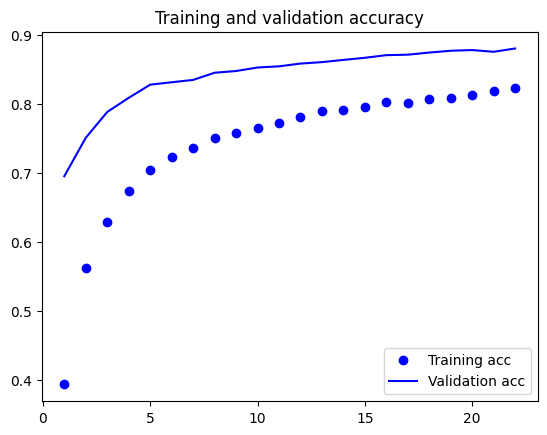

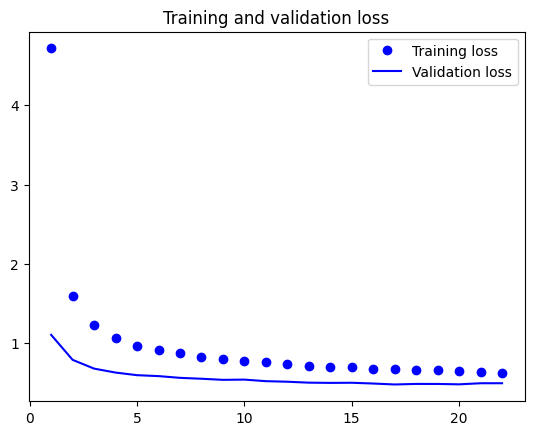

In [ ]:
#Displaying curves of loss and accuracy

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#We can later load it and test it:
#loaded_model = keras.models.load_model('/content/drive/MyDrive/ProjetoIA/models/CNN_modeloT_TL_FT_with_DA.h5')
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)

313/313 [==============================] - 87s 277ms/step - loss: 0.4909 - accuracy: 0.8808
val_acc: 0.8808000087738037


Foram avaliados 313 batches no conjunto de validação
Perda calculada no conjunto de validação 0.4909
Previsão do conjunto de validação com 88.08% das previsões foram corretas.